In [33]:
# Fix OpenCV dependency in Colab
!apt-get install -y libgl1-mesa-glx

import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import os
import joblib

# Enhanced feature extraction with vessel density
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Vessel detection
    edges = cv2.Canny(enhanced, 50, 150)
    vessel_density = np.mean(edges)

    # Texture features
    glcm = cv2.calcHist([enhanced], [0], None, [256], [0,256])
    glcm = cv2.normalize(glcm, None).flatten()

    # Shape features
    moments = cv2.HuMoments(cv2.moments(edges)).flatten()

    return [
        np.mean(enhanced),          # Global intensity
        np.std(enhanced),           # Contrast
        vessel_density,             # Edge density
        enhanced[200:300, 200:300].mean(),  # Center region
        glcm[100],                  # Texture measure
        moments[0],                 # Hu moment 1
        moments[1]                  # Hu moment 2
    ]

# Load data with average CDR and labels
df = pd.read_csv('drishti_labels.csv')
df['cdr'] = df[['cdr1','cdr2','cdr3','cdr4']].mean(axis=1)
df['cdr'] = df['cdr1']

# Feature extraction with augmentation
X, y, img_names = [], [], []
for _, row in df.iterrows():
    img_path = row['image_path']
    feats = extract_features(img_path)
    if feats:
        X.append(feats)
        y.append(row['cdr'])
        img_names.append(os.path.basename(img_path))

        # Data augmentation - horizontal flip
        img_flipped = cv2.flip(cv2.imread(img_path), 1)
        flipped_path = 'temp_flipped.jpg'
        cv2.imwrite(flipped_path, img_flipped)
        feats_flipped = extract_features(flipped_path)
        if feats_flipped:
            X.append(feats_flipped)
            y.append(row['cdr'])
            img_names.append(os.path.basename(img_path) + '_flipped')
        os.remove(flipped_path)  # Clean up temp file

X_train, X_test, y_train, y_test, img_names_train, img_names_test = train_test_split(
    X, y, img_names,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# 2. Fit scaler and selector on training data only
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(mutual_info_regression, k=5).fit(X_train_scaled, y_train)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Feature selection
#X = StandardScaler().fit_transform(X)
#elector = SelectKBest(mutual_info_regression, k=5)
#X_selected = selector.fit_transform(X, y)

# Split data (keep track of image names)
#X_train, X_test, y_train, y_test, img_names_train, img_names_test = train_test_split(
 #   X_selected, y, img_names,
  #  test_size=0.2,
   # shuffle=True,
    #random_state=42
#)
X_train=X_train_selected
X_test=X_test_selected
print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 10, None]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_absolute_error')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Hyperparameter tuning for SVR
svr_param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}
svr = SVR()
svr_grid = GridSearchCV(svr, svr_param_grid, cv=3, scoring='neg_mean_absolute_error')
svr_grid.fit(X_train, y_train)
best_svr = svr_grid.best_estimator_

# Ensemble model (VotingRegressor)
ensemble = VotingRegressor([
    ('rf', best_rf),
    ('svr', best_svr)
])
ensemble.fit(X_train, y_train)

# Evaluate
test_pred = ensemble.predict(X_test)
predicted_labels = (test_pred > 0.65).astype(int)
true_labels = (np.array(y_test) > 0.65).astype(int)

# Print results
print("\n=== Enhanced Test Results ===")
print(f"{'Index':<6} | {'Image':<25} | {'Actual CDR':<10} | {'Predicted CDR':<12} | {'Actual Label':<12} | {'Predicted Label':<14} | {'Correct':<6}")
print("-" * 120)
correct_count = 0
for idx, (actual_cdr, pred_cdr, actual_label, pred_label, img_name) in enumerate(zip(y_test, test_pred, true_labels, predicted_labels, img_names_test)):
    correct = actual_label == pred_label
    correct_count += int(correct)
    print(f"{idx:<6} | {img_name:<25} | {actual_cdr:.4f}     | {pred_cdr:.4f}      | {actual_label:<12} | {pred_label:<14} | {'Yes' if correct else 'No'}")

# Calculate metrics
mae = mean_absolute_error(y_test, test_pred)
accuracy = accuracy_score(true_labels, predicted_labels)

print("\n=== Performance Metrics ===")
print(f"Test MAE (CDR): {mae:.4f}")
print(f"Label Accuracy: {accuracy:.2%}")
print(f"Optimal Threshold: 0.65")
print(f"Best RF Params: {rf_grid.best_params_}")
print(f"Best SVR Params: {svr_grid.best_params_}")

# Save during training
import joblib
joblib.dump({
    'model': ensemble,
    'scaler': scaler,
    'selector': selector
}, "ensemble_model.pkl")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

Train set size: 161
Test set size: 41

=== Enhanced Test Results ===
Index  | Image                     | Actual CDR | Predicted CDR | Actual Label | Predicted Label | Correct
------------------------------------------------------------------------------------------------------------------------
0      | drishtiGS_048.png_flipped | 0.7500     | 0.7789      | 1            | 1              | Yes
1      | drishtiGS_008.png_flipped | 0.5700     | 0.7885      | 0            | 1              | No
2      | drishtiGS_016.png         | 0.9000     | 0.7461      | 1            | 1              | Yes
3      | drishtiGS_080.png_flipped | 0.7700     | 0.8245      | 1            | 1              | Yes
4      | drishtiGS_094.png         | 0.3100     | 0.3984      | 0    

['ensemble_model.pkl']

In [44]:
#Demo
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded from ensemble_model.pkl


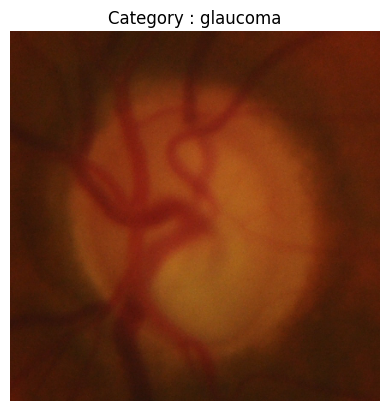

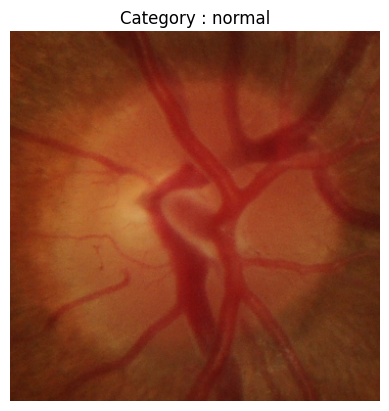

Actual image : Glaucoma , Predicted CDR : 0.6675623641789064
Glaucoma
Actual image : Normal , Predicted CDR : 0.4665111105804891
Normal


In [46]:
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
# Set paths
models_path = "/content/drive/MyDrive/IPML/Ensemble"

# Load during inference
saved_data = joblib.load(f"{models_path}/ensemble_model.pkl")
loaded_model = saved_data['model']
loaded_scaler = saved_data['scaler']
loaded_selector = saved_data['selector']
print("Model loaded from ensemble_model.pkl")

# Image dimensions
img_height, img_width = 224, 224

dataset_path = "/content/drive/MyDrive/dataset/RIM_ONE"

# Enhanced feature extraction with vessel density
def extract_features(image_path,category):
    img = cv2.imread(image_path)
    img1=img
    img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # Convert for correct color display

    plt.imshow(img_rgb)
    plt.title(f"Category : {category}")  # Add your desired title
    plt.axis('off')  # Optional: hides axis ticks
    plt.show()
    if img is None:
        return None

    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Vessel detection
    edges = cv2.Canny(enhanced, 50, 150)
    vessel_density = np.mean(edges)

    # Texture features
    glcm = cv2.calcHist([enhanced], [0], None, [256], [0,256])
    glcm = cv2.normalize(glcm, None).flatten()

    # Shape features
    moments = cv2.HuMoments(cv2.moments(edges)).flatten()

    return [
        np.mean(enhanced),          # Global intensity
        np.std(enhanced),           # Contrast
        vessel_density,             # Edge density
        enhanced[200:300, 200:300].mean(),  # Center region
        glcm[100],                  # Texture measure
        moments[0],                 # Hu moment 1
        moments[1]                  # Hu moment 2
    ]

def load_random_image(category):
    """Load a random image from the specified category folder"""
    folder_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random_file = random.choice(image_files)

    # Load and preprocess the image
    img_path = os.path.join(folder_path, random_file)

    return img_path

# Load random images
glaucoma_img_path = load_random_image("glaucoma")
normal_img_path= load_random_image("normal")

def predict_cdr(image_path,category):
    # 1. Extract features
    feats = extract_features(image_path,category)
    if feats is None:
        return None

    # 2. Scale using TRAINED scaler
    feats_scaled = loaded_scaler.transform([feats])

    # 3. Select features using TRAINED selector
    feats_selected = loaded_selector.transform(feats_scaled)

    # 4. Predict
    return loaded_model.predict(feats_selected)[0]


#predict
ensemble_pred1 = predict_cdr(glaucoma_img_path,"glaucoma")
ensemble_pred2 = predict_cdr(normal_img_path,"normal")
predicted_label1 = (ensemble_pred1 > 0.65).astype(int)
predicted_label2 = (ensemble_pred2 > 0.65).astype(int)

print(f"Actual image : Glaucoma , Predicted CDR : {ensemble_pred1}")
if predicted_label1==1:
  print("Glaucoma")
else:
  print("Normal")

print(f"Actual image : Normal , Predicted CDR : {ensemble_pred2}")
if predicted_label2==1:
  print("Glaucoma")
else:
  print("Normal")

In [ ]:
import joblib

# Save all needed components
joblib.dump(ensemble, 'ensemble_cdr_model.pkl')
joblib.dump(selector, 'selector.pkl')
joblib.dump(StandardScaler().fit(X), 'scaler.pkl')  # Save the fitted scaler